In [1]:
%pip install langchain langchain-google-genai "langchain[docarray]" faiss-cpu pypdf

In [7]:
%pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.19
    Uninstalling langchain-0.3.19:
      Successfully uninstalled langchain-0.3.19


In [2]:
import os
import requests
from PIL import Image

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Markdown

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage

In [8]:
from langchain.vectorstores import DocArrayInMemorySearch

In [9]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [10]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [11]:
from langchain.schema.document import Document
from langchain_community.document_loaders import TextLoader

In [12]:
from langchain_text_splitters import CharacterTextSplitter

In [13]:
from langchain_community.vectorstores import FAISS

In [14]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Model Selection

In [29]:
def load_model(model_name):
  if model_name == "gemini-pro":
    llm = ChatGoogleGenerativeAI(model = "gemini-1.5-pro")
  else:
    llm = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")

  return llm

In [22]:
model_text = load_model("gemini-1.5-flash")

### Text Generate

In [23]:
model_text.invoke("Tell me a funny joke").content

"Why don't scientists trust atoms? \n\nBecause they make up everything!"

## Image Based

In [24]:
def get_image(url,filename,extension):
  content = requests.get(url).content
  with open(f'/content/{filename}.{extension}', 'wb') as f:
    f.write(content)
  image = Image.open(f"/content/{filename}.{extension}")
  image.show()
  return image

In [25]:
image = get_image("https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/1705ca64-fbc8-4b79-a451-4ab77760c219/dunk-low-older-shoes-C7T1cx.png",
                  "nike-shoes",
                  "png")

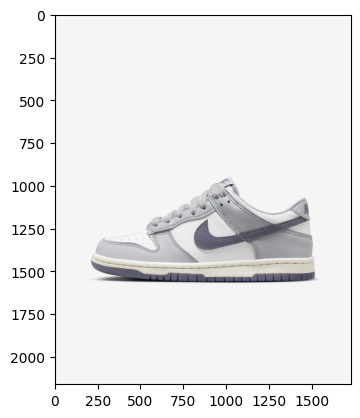

In [28]:
plt.imshow(image)
plt.show()

In [30]:
model = load_model("gemini-pro-vision")

In [31]:
prompt = "Give me summary of this image in 5 words"

In [36]:
message = HumanMessage(
    content=[
        {

            "type": "image_url",
            "image_url": "https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/1705ca64-fbc8-4b79-a451-4ab77760c219/dunk-low-older-shoes-C7T1cx.png"
        }
    ]
)

In [37]:
print(model.invoke([message]).content)

Here is a description of the image:

Close-up view of a single Nike Dunk Low sneaker, presented against a plain white background. 


Here's a breakdown of the shoe's appearance:

* **Colorway:** The shoe is predominantly a light gray or off-white, with a slightly darker gray or lavender-toned accents on the Nike swoosh and heel tab. The midsole is an off-white or beige.

* **Style:** It's a low-top sneaker with the classic Dunk design elements: a perforated toe box, a padded low-cut collar, and the iconic Nike swoosh.

* **Materials:** The shoe appears to be made of leather or a leather-like material.

* **Angle:** The shoe is presented in a three-quarter profile view, allowing a clear view of the side, toe, and heel.

The overall impression is one of a clean, minimalist, and stylish sneaker. The lighting is even and bright, showcasing the shoe's details effectively.


In [38]:
message2 = HumanMessage(
    content=[
        {
            "type": "text",
            "text": prompt,
        },
        {

            "type": "image_url",
            "image_url": "https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/1705ca64-fbc8-4b79-a451-4ab77760c219/dunk-low-older-shoes-C7T1cx.png"
        }
    ]
)

In [40]:
print(model.invoke([message2]).content)

Grey Nike Dunk Low shoe.


## Load File with Langchain

In [42]:
loader = TextLoader("Nike.txt")
print(loader.load()[0].page_content)

Nike shoes are produced in Indonesia, China, Taiwan, India, Thailand, Vietnam, Pakistan,
Philippines, and Malaysia.
Nike does not have any factories to produce shoes located in the U.S so all of their shoes are
imported from these countries. This is the area in which Nike has a lot of controversy.
Nike has still remained at the top of the industry controlling 33 percent of global athletic footwear
sales and 36 percent in the United States
In the 1990s Nike was heavily criticized by human rights and environmental organizations for
poor working conditions and low wages… At first Nike took a very hands-off approach and
refused to acknowledge the problems. They said the issues were not with their workers since
they contracted out their manufacturing and so Nike did not feel any responsibility towards
them.
Since Nike does not own any of the factories that produce their shoes, they do not tend to run
into any problems when having resources or shoes shipped. However, Nike has not made any
st

## Creating RAG

In [43]:
def get_text_chunks_langchain(text):
  text_splitter = CharacterTextSplitter(chunk_size = 20, chunk_overlap = 10)
  docs = [Document(page_content = x) for x in text_splitter.split_text(text)]
  return docs

In [44]:
text = loader.load()[0].page_content

In [45]:
docs = get_text_chunks_langchain(text)

In [46]:
embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")

In [47]:
vectorstore = FAISS.from_documents(docs, embedding = embeddings)

In [48]:
retriever = vectorstore.as_retriever()

In [51]:
print(retriever.invoke("Nike slide/sandal."))

[Document(id='c2a9ef7f-916c-4a3c-80c2-af7be2a0d7eb', metadata={}, page_content='Nike shoes are produced in Indonesia, China, Taiwan, India, Thailand, Vietnam, Pakistan,\nPhilippines, and Malaysia.\nNike does not have any factories to produce shoes located in the U.S so all of their shoes are\nimported from these countries. This is the area in which Nike has a lot of controversy.\nNike has still remained at the top of the industry controlling 33 percent of global athletic footwear\nsales and 36 percent in the United States\nIn the 1990s Nike was heavily criticized by human rights and environmental organizations for\npoor working conditions and low wages… At first Nike took a very hands-off approach and\nrefused to acknowledge the problems. They said the issues were not with their workers since\nthey contracted out their manufacturing and so Nike did not feel any responsibility towards\nthem.\nSince Nike does not own any of the factories that produce their shoes, they do not tend to run\

In [52]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [53]:
llm_vision = load_model("gemini-1.5-pro")

In [78]:
template = """
```
{context}
```

{query}


Provide brief information.
"""

In [79]:
prompt = ChatPromptTemplate.from_template(template)

Creating Rag-chain from multimodeling

In [56]:
rag_chain = (
    {"context": retriever, "query": RunnablePassthrough()}
    | prompt
    | llm_vision
    | StrOutputParser()
)

In [59]:
result = rag_chain.invoke("can you give me a detail of nike manufacturing?")

In [60]:
display(Markdown(result))

Nike does not own any of the factories that produce its shoes.  Manufacturing is outsourced to factories in Indonesia, China, Taiwan, India, Thailand, Vietnam, Pakistan, Philippines, and Malaysia.  Nike has faced significant criticism for labor practices and worker conditions in these factories, including low wages, excessive working hours, and unsafe conditions.  The company has not publicly committed to the Fair Trade movement.

Nike stores are located globally;  the provided text doesn't list specific store locations.

In [61]:
rag_chain

{
  context: VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7d3efa6439d0>, search_kwargs={}),
  query: RunnablePassthrough()
}
| ChatPromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, template='\n```\n{context}\n```\n\n{query}\n\n\nProvide brief information and store location.\n'), additional_kwargs={})])
| ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7d3eeb94c150>, default_metadata=())
| StrOutputParser()

In [62]:
full_chain = (
    RunnablePassthrough() | llm_vision | StrOutputParser() | rag_chain
)

In [70]:
url_1 = "https://images.squarespace-cdn.com/content/v1/5810dda3e3df28ce37b58357/1501169806667-4CH93LTDEUNLD9VKCZER/image-asset.jpeg?format=1000w"

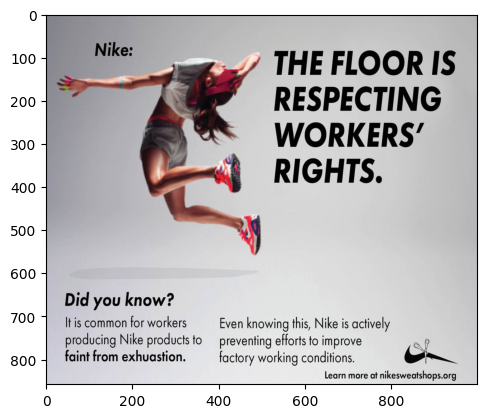

In [71]:
image = get_image(url_1, "nike3", "png")


plt.imshow(image)
plt.show()

In [75]:
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "Provide information on given image context.",
        },  # You can optionally provide text parts
        {"type": "image_url", "image_url": url_1},
    ]
)

In [80]:
result = full_chain.invoke([message])

In [81]:
display(Markdown(result))

The provided text describes an advertisement critical of Nike's labor practices, not a store location.  There is no information about a physical store location.  The ad mentions the website "nikesweatshops.org" as a source for further information.